In [2]:
from sklearn.datasets import fetch_openml
minst = fetch_openml('mnist_784', version=1)
minst.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

RangeIndex(start=0, stop=70000, step=1)


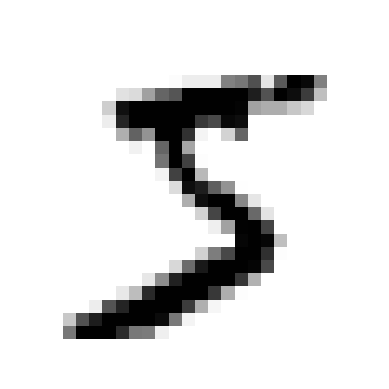

'5'

In [3]:
# Let's look at the data (X) and labels (y)
X, y = minst['data'], minst['target']

# X = 70000 images and each image has 784 features (i.e., 28x28 pixels)
# y = 70000 labels

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Print the index of the DataFrame
print(X.index)

# Correctly access the first row of the DataFrame
some_digit = X.iloc[0]  # Use .iloc to access by integer position
some_digit_image = some_digit.values.reshape(28, 28)  # Convert to array and reshape

# Display the image
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')  # cmap is color map
plt.axis('off')
plt.show()

# Print the label
y[0]

In [4]:
y = y.astype(np.uint8)  # Convert the labels to integers 

In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Train a binary classifier
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

/home/borse_saurabh/ros2_ws/ws_machinel/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [6]:
# Measure the accuracy using cross-validation
# Implementing cross-validation from scratch

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# In this for loop we are training the model on 2/3 of the data and testing on 1/3
# We do this 3 times and calculate the accuracy each time
# THe procedure is called K-fold cross-validation, and it consist of splitting the training set into K-folds
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))



0.9669
0.91625
0.96785


In [7]:
# Using cross_val_score() function to evaluate the model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [8]:
# Confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [9]:
# computing preciousion and recall
from sklearn.metrics import precision_score, recall_score
precision_score_ = precision_score(y_train_5, y_train_pred)
print(f"precision score: {precision_score_}")
recall_score_ = recall_score(y_train_5, y_train_pred)
print(f"recall score: {recall_score_}")

precision score: 0.8370879772350012
recall score: 0.6511713705958311


In [10]:
# computing F1 score
from sklearn.metrics import f1_score
f1_score_ = f1_score(y_train_5, y_train_pred)
print(f"F1 score: {f1_score_}")

F1 score: 0.7325171197343847


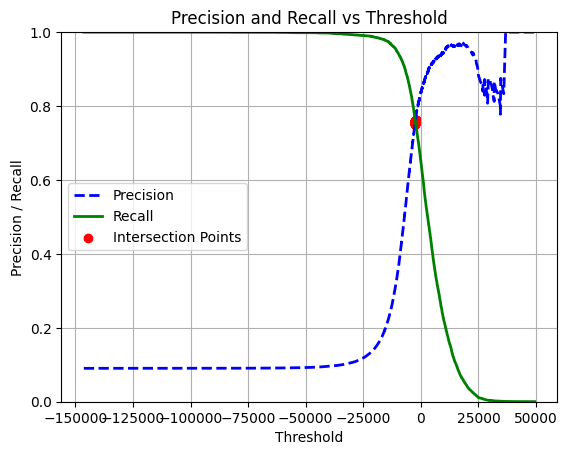

In [11]:
# Precision/Recall tradeoff
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

import numpy as np
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # Plot Precision and Recall curves
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    
    # Find intersection points where precision == recall
    intersection_idx = np.where(np.isclose(precisions[:-1], recalls[:-1], atol=1e-2))[0]
    
    # Plot intersection points
    plt.scatter(thresholds[intersection_idx], precisions[intersection_idx], color='red', label='Intersection Points')

    # Labels and formatting
    plt.xlabel('Threshold')
    plt.ylabel('Precision / Recall')
    plt.title('Precision and Recall vs Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    
    # Show grid and plot
    plt.grid(True)

# Use your existing data and call the modified function
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()




precision score 90: 0.9000345901072293
recall score 90: 0.4799852425751706


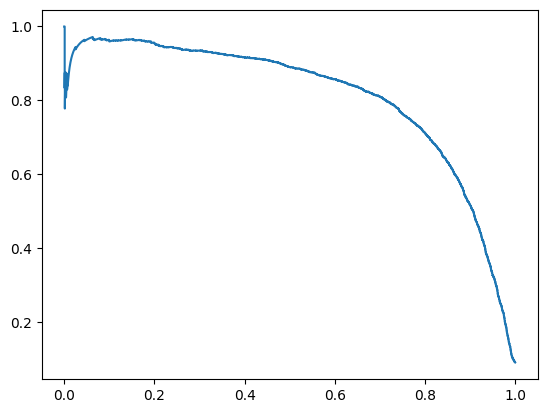

In [12]:
# Precision vs Recall
plt.plot(recalls, precisions)

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score_90 = precision_score(y_train_5, y_train_pred_90)
print(f"precision score 90: {precision_score_90}")
recall_score_90 = recall_score(y_train_5, y_train_pred_90)
print(f"recall score 90: {recall_score_90}")

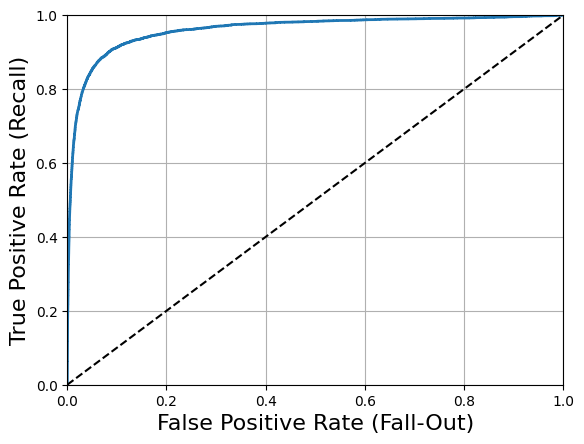

roc_auc_score_SGDclassifier: 0.9604938554008616


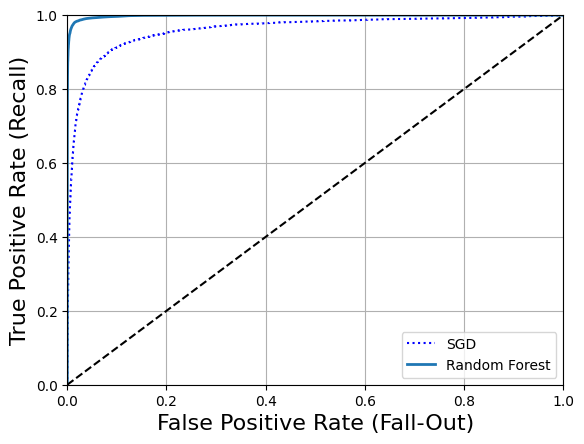

In [13]:
# ROC curve

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                     
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)     

plot_roc_curve(fpr, tpr)
plt.show()          

# Compute the area under the curve (AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
print(f"roc_auc_score_SGDclassifier: {roc_auc_score(y_train_5, y_scores)}")

# Train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')   
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [13]:
# Multiclass classification
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

# In this case, Scikit-Learn used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.


/home/borse_saurabh/ros2_ws/ws_machinel/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [ ]:
# Using the decision_function() method to get the scores which were used to make the predictions
# It represents the score that the model assigned to each class
some_digit_scores = svm_clf.decision_function([some_digit])
print(f"some_digit_scores: {some_digit_scores}")

np.argmax(some_digit_scores)
print(f"svm_clf.classes_: {svm_clf.classes_}")

# If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
print(f"len(ovr_clf.estimators_): {len(ovr_clf.estimators_)}")


/home/borse_saurabh/ros2_ws/ws_machinel/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


some_digit_scores: [[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
svm_clf.classes_: [0 1 2 3 4 5 6 7 8 9]


In [14]:
# Training an SGDClassifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
print(f"sgd_clf.decision_function([some_digit]): {sgd_clf.decision_function([some_digit])}")
crossval_score_sgd = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy') # Evaluate the model using cross_val_score()
print(f"crossval_score_sgd: {crossval_score_sgd}")

# Scaling the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score_withscaler = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
print(f"cross_val_score_withscaler: {cross_val_score_withscaler}")


/home/borse_saurabh/ros2_ws/ws_machinel/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/home/borse_saurabh/ros2_ws/ws_machinel/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


sgd_clf.decision_function([some_digit]): [[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
crossval_score_sgd: [0.87365 0.85835 0.8689 ]
cross_val_score_withscaler: [0.8983 0.891  0.9018]


conf_mx: [[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


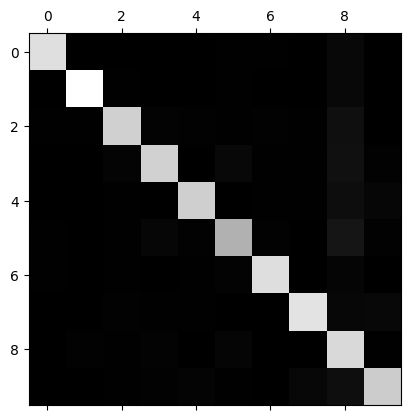

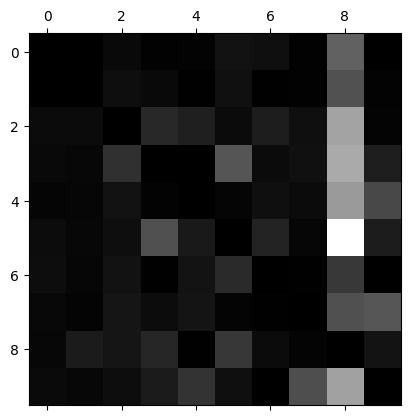

In [15]:
# Error Analysis
# Lets assume that you have found a promising model and you want to find ways to improve it

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(f"conf_mx: {conf_mx}")
# Plot the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# Divide each value in the confusion matrix by the number of images in the corresponding class
# This will give you an error rate rather than an absolute number of errors

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)  # Fill the diagonal with zeros to keep only the errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()